# Lab 8 - Model Evaluation and Selection

In this lab, we will quantify a models performance and compare different models. Specifically we will: 
* split datasets into training, cross validation (cv) and test sets
* evaluate regression and classification models
* add polynomial features to improve the performance solely of a linear regression model
* compare several neural network architectures

## Imports

In [3]:
# Array computations, loading data
import numpy as np

# building linear regression models, preparing data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# building and training neural networks
import tensorflow as tf

# custom functions
import utils

# reduce display precisions on numpy arrays
np.set_printoptions(precision = 2)

# suppress warnings
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(0)

## The dataset

We want to develop a linear regression model. But first, we need to load the data. The dataset has 50 examples of an input feature X and corresponding target Y. 

In [4]:
# Load the dataset from a textfile
data = np.loadtxt("./data/data_w3_ex1.csv", delimiter = ",")

# Split inputs and outputs into arrays x and y
x = data[:,0]
y = data[:,1]

# Convert 1D arrays inta a 2D arrays for later use
x = np.expand_dims(x, axis = 1)
y = np.expand_dims(y, axis = 1)

print(f"The shape of the inputs x is: {x.shape}")
print(f"The shape of the targets y is: {y.shape}")

The shape of the inputs x is: (50, 1)
The shape of the targets y is: (50, 1)


Plotting the x,y data to get a better idea of what we are working with. 

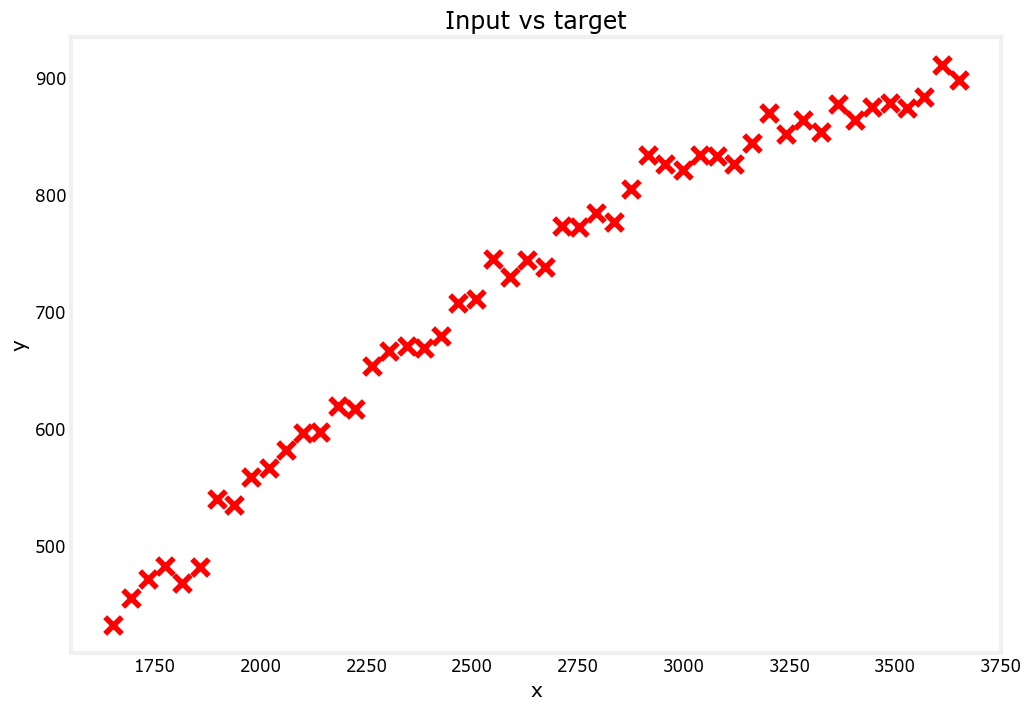

In [5]:
# Custom function
utils.plot_dataset(x = x, y = y, title = "Input vs target")

Note: Looks like a logarithmic relationship. 

## Splitting the dataset into training, cross validation, and test sets

The *training set* is used to train the model. The *cross validation / development / dev set* is used to evaluate different model configurations. The *test set* acts like new data to see how the model performs with new data. 

The scikit-learn module provides a function **train_test_split** to split any data, but not directly into the three sets mentioned above. We can define what percentage of the data goes to each set. 

In [7]:
# 60% of the dataset will be used as training set. The other 40% will be stored as x_ and y_. 
x_train, x_, y_train, y_ = train_test_split(x, y, test_size = 0.40, random_state = 1)

# The remaining data (x_, y_) will be split equally into the cv and testing set. 
x_cv, x_test, y_cv, y_test = train_test_split(x_, y_, test_size = 0.50, random_state = 1)

# Delete x_ and y_ since they were used temporarily
del x_, y_

print(f"the shape of the training set (input) is: {x_train.shape}")
print(f"the shape of the training set (target) is: {y_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_test.shape}")
print(f"the shape of the test set (target) is: {y_test.shape}")

the shape of the training set (input) is: (30, 1)
the shape of the training set (target) is: (30, 1)

the shape of the cross validation set (input) is: (10, 1)
the shape of the cross validation set (target) is: (10, 1)

the shape of the test set (input) is: (10, 1)
the shape of the test set (target) is: (10, 1)


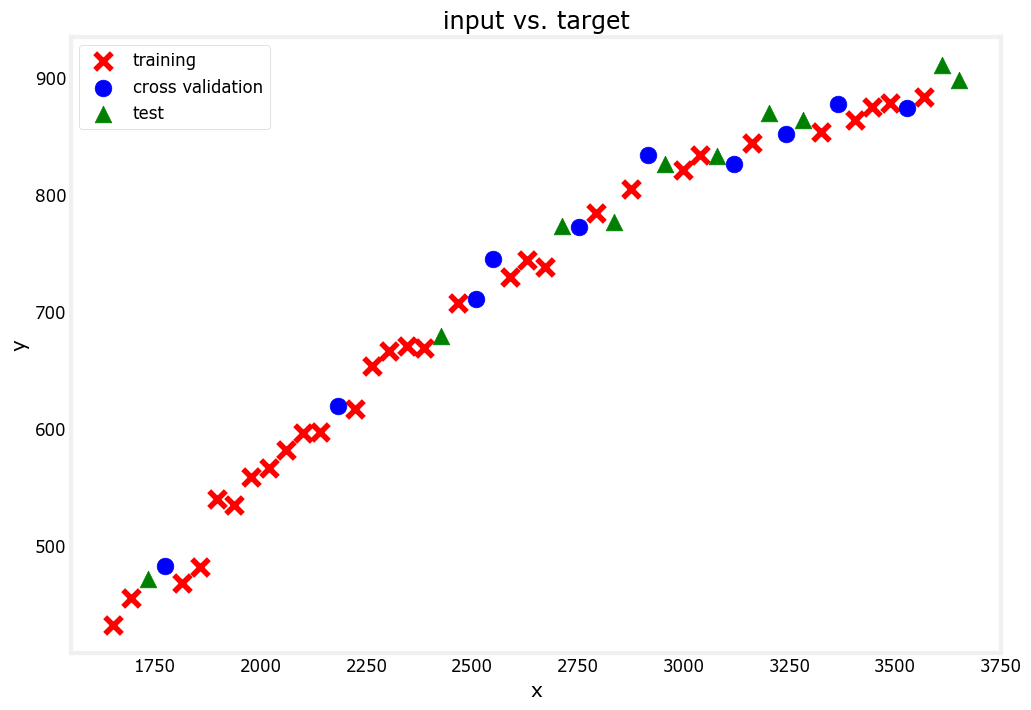

In [8]:
# Plot the data using a custom function
utils.plot_train_cv_test(x_train, y_train, x_cv, y_cv, x_test, y_test, title="input vs. target")

## Fit a model
We will now fit a linear model. 

### Feature Scaling

Feature scaling is used to make the model converge quickly. It is also used for data with a input features that widely range. 

We will use the **StandardScaler** from SciKit-Learn to compute the z-score of the imports. $ z = \frac{x - \mu}{\sigma} $


Computed mean of the training set: 2504.06
Computed standard deviation of the training set: 574.85


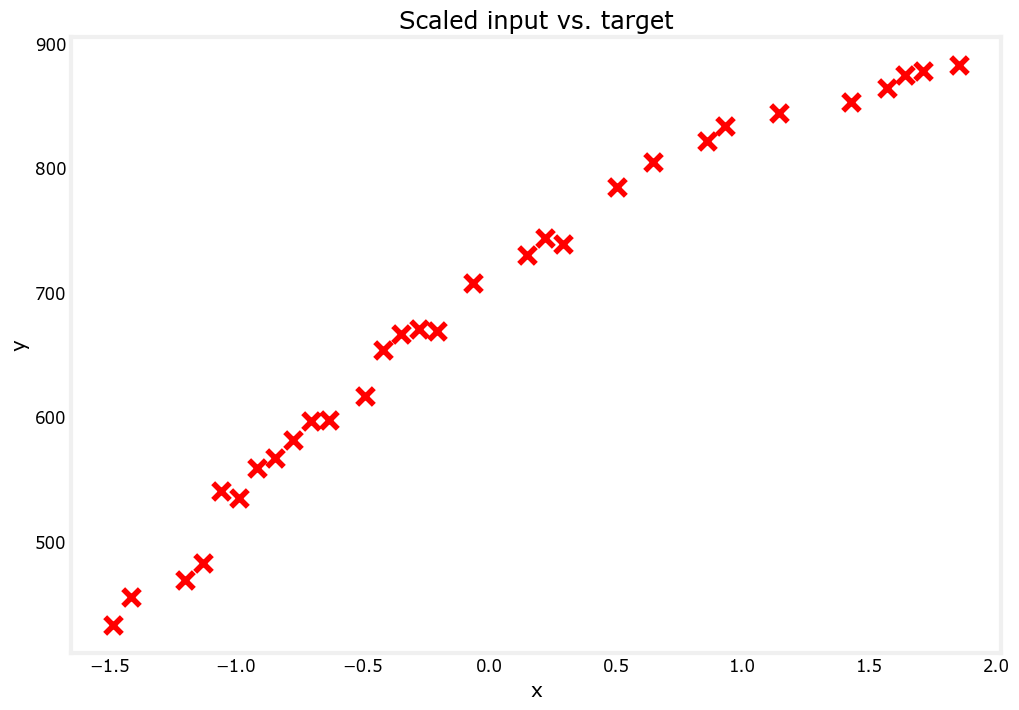

In [9]:
# Initialise the class
scaler_linear = StandardScaler()

# Compute the mean, std and then transform the dataset
X_train_scaled = scaler_linear.fit_transform(x_train)

print(f"Computed mean of the training set: {scaler_linear.mean_.squeeze():.2f}")
print(f"Computed standard deviation of the training set: {scaler_linear.scale_.squeeze():.2f}")

# Plot the results
utils.plot_dataset(x = X_train_scaled, y = y_train, title = "Scaled input vs. target")

Note: The x-axis has changed from 1750-3750 to -1.5-2.0. The y-axis remains unchanged. 

### Train the model
Using the LinearRegression class. 

In [10]:
# Initialise the class
linear_model = LinearRegression()

# Train
linear_model.fit(X_train_scaled, y_train)

LinearRegression()

### Evaluate the model
We will use the mean_squared_error as a measure of error for the training and cross validation error. 

SciKit-learn provides a **mean_squared_error()** function. This only divides by m, not 2m. 

We will use the scaled training set.

In [11]:
# Calculate the predictions from the model
yhat = linear_model.predict(X_train_scaled)

# Calculate the MSE of the training set and divide by 2
print(f"training MSE (using sklearn function): {mean_squared_error(y_train, yhat) / 2}")

# Check
total_squared_error = 0
for i in range(len(yhat)):
    squared_error_i  = (yhat[i] - y_train[i])**2
    total_squared_error += squared_error_i                                              
mse = total_squared_error / (2*len(yhat))
print(f"training MSE (for-loop implementation): {mse.squeeze()}")

training MSE (using sklearn function): 406.19374192533155
training MSE (for-loop implementation): 406.19374192533155


Computing the MSE of the cross validation set requires some extra knowledge: 
1. Scale the cross-validation set the same as we scaled the training set.
2. **BUT** use the mean and the std of the training set to calculate the z-score to ensure consistent transformation of the input data.
3. We can use the StandardScaler´s **transform()** function instead of the **fit_transform()** function.

In [12]:
# Scale the cross-validation set using the mean, std of the training set
X_cv_scaled = scaler_linear.transform(x_cv)

print(f"Mean used to scale the CV set: {scaler_linear.mean_.squeeze():.2f}")
print(f"Standard deviation used to scale the CV set: {scaler_linear.scale_.squeeze():.2f}")

# Feed the scaled cross validation set
yhat = linear_model.predict(X_cv_scaled)

# Use scikit-learn's utility function and divide by 2
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")

Mean used to scale the CV set: 2504.06
Standard deviation used to scale the CV set: 574.85
Cross validation MSE: 551.7789026952216


Note: MSE of the training set is 406 and for the cv set is 551.  

## Adding Polynomial Features
Noticing the non-linear relationship between x and y tells us that we will need a non-linear model. We can do this by adding polynomial features. 

### Creating additional features
1. Generate polynomial features from the training set using the ***PolynomialFeatures*** class. It creates a new input feature which has the squared values of the input (degree = 2)
2. Scale the inputs
3. Train the model
4. Measure the model vs the cross validation set 

In [13]:
# Instantiate the class to make polynomial features
poly = PolynomialFeatures(degree = 2, include_bias = False)

# Compute the number of features and transform the training set
X_train_mapped = poly.fit_transform(x_train)

print(X_train_mapped[:5])

[[3.32e+03 1.11e+07]
 [2.34e+03 5.50e+06]
 [3.49e+03 1.22e+07]
 [2.63e+03 6.92e+06]
 [2.59e+03 6.71e+06]]


In [14]:
# Scale inputs
scaler_poly = StandardScaler()

# Compute the mean, std of the training set and transform
X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)

# Preview the first 5 elements
print(X_train_mapped_scaled[:5])

[[ 1.43  1.47]
 [-0.28 -0.36]
 [ 1.71  1.84]
 [ 0.22  0.11]
 [ 0.15  0.04]]


In [16]:
# Train Model
model = LinearRegression()
model.fit(X_train_mapped_scaled, y_train)

# Compute the training MSE
yhat = model.predict(X_train_mapped_scaled)
print(f"Training MSE: {mean_squared_error(y_train, yhat) / 2}")

# Add the polynomial features to the cross validation set
X_cv_mapped = poly.transform(x_cv)

# Scale the cross validation set using the mean, std of the training set
X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

# Compute the cv MSE
yhat = model.predict(X_cv_mapped_scaled)
print(f"Cross validation MSE: {mean_squared_error(y_cv, yhat) / 2}")


Training MSE: 49.11160933402504
Cross validation MSE: 87.69841211111934


Note: MSE is lower (roughly 1/10th) when a second degree is used. 

## Automate adding polynomials in a loop

In the next cells, we will repeat what we just did, however with models with degrees 1-10. We can then find the degree of the best model before using our test set. 

Degree = 1, Train MSE = 406.19, Cross Validation MSE = 551.78
Degree = 2, Train MSE = 49.11, Cross Validation MSE = 87.70
Degree = 3, Train MSE = 47.62, Cross Validation MSE = 81.15
Degree = 4, Train MSE = 47.15, Cross Validation MSE = 79.43
Degree = 5, Train MSE = 47.14, Cross Validation MSE = 79.59
Degree = 6, Train MSE = 41.38, Cross Validation MSE = 98.74
Degree = 7, Train MSE = 39.25, Cross Validation MSE = 99.32
Degree = 8, Train MSE = 38.98, Cross Validation MSE = 99.05
Degree = 9, Train MSE = 37.97, Cross Validation MSE = 109.59
Degree = 10, Train MSE = 37.04, Cross Validation MSE = 121.85


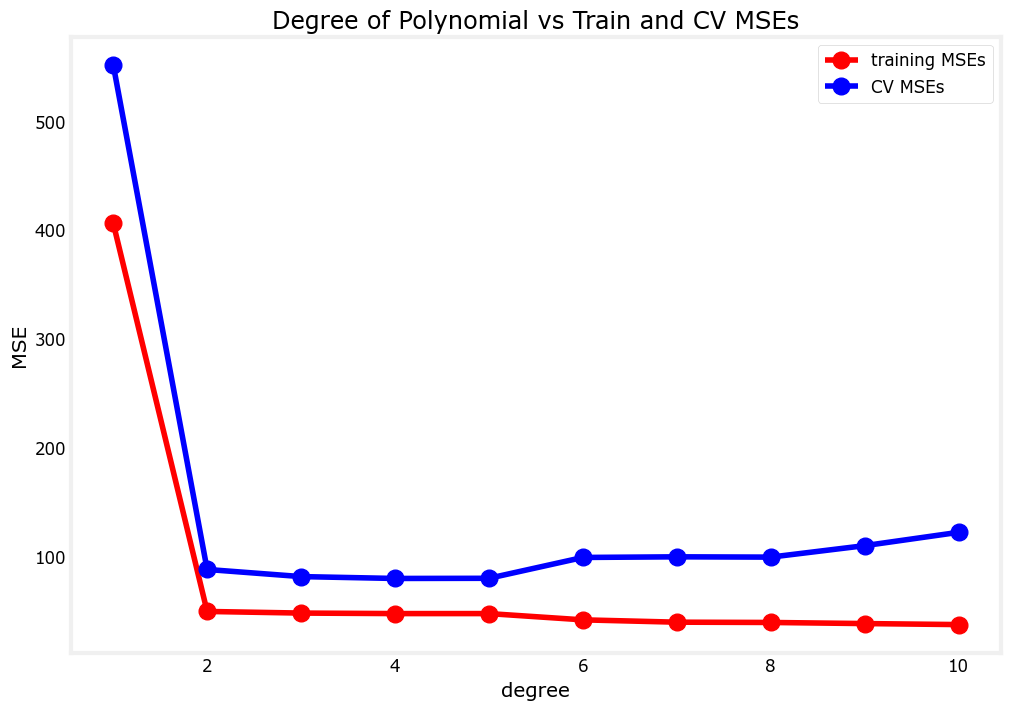

In [27]:
# Initiaise lists to save errors, models, feature transforms
train_mses = []
cv_mses = []
models = []
polys = []
scalers = []

# Loop 10 times, adding one degree higher than the previous model
for degree in range(1,11): 

    # Add polynomial feature to the training set
    poly = PolynomialFeatures(degree, include_bias = False)
    X_train_mapped = poly.fit_transform(x_train)              # fit the model
    polys.append(poly)                                        # store poly

    # Scale the training set
    scaler_poly = StandardScaler()
    X_train_mapped_scaled = scaler_poly.fit_transform(X_train_mapped)
    scalers.append(scaler_poly)

    # Create and train the model
    model = LinearRegression()
    model.fit(X_train_mapped_scaled, y_train)
    models.append(model)                                      # store model

    # Compute the training MSE
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    train_mses.append(train_mse)                              # store train mse

    # Add polynomial feature and scale the cross validation set
    X_cv_mapped = poly.transform(x_cv)
    X_cv_mapped_scaled = scaler_poly.transform(X_cv_mapped)

    # Compute the cross validation MSE
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    cv_mses.append(cv_mse)

    print(f"Degree = {degree}, Train MSE = {train_mse:.2f}, Cross Validation MSE = {cv_mse:.2f}")

# Plot result
degrees = range(1,11)
utils.plot_train_cv_mses(degrees, train_mses, cv_mses, title = "Degree of Polynomial vs Train and CV MSEs")
 

Degree 4 has the lowest/best Cross Validation MSE and the corresponding Training MSE is only 0.01 higher than the lowest/best Training MSE. 

## Choosing the best model
When choosing a model, the best model performs well on the training set and the cv set. The cv error generally increases with higher degree polynomial models. Hence, the model with the lowest CV is generally the best start. 

In [28]:
# Get the model with the lowest CV MSE
degree = np.argmin(cv_mses) + 1
print(f"Lowest CV MSE is found in the model with degree = {degree}")

Lowest CV MSE is found in the model with degree = 4


Now we can compute the test MSE as the ***generalisation error***. 

In [30]:
# Add polynomial deatures to the test set
X_test_mapped = polys[degree-1].transform(x_test)

# Scale the test set
X_test_mapped_scaled = scalers[degree-1].transform(X_test_mapped)

# Compute the test MSE
yhat = models[degree-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Training MSE: {train_mses[degree-1]:.2f}")
print(f"Cross Validation MSE: {cv_mses[degree-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

Training MSE: 47.15
Cross Validation MSE: 79.43
Test MSE: 104.63


As predicted, the test MSE will be higher than those of the training or cross validation set. 

## Neural Networks
In this section, we will repeat what we did before, but with a neural network architecture. 

### Prepare the data. 
We will use the same training, cv and testing set from the previous section. We do not need to add polynomial features and our degree will be the default (1). 

In [32]:
# Define the sets
degree = 1
poly = PolynomialFeatures(degree, include_bias = False)
X_train_mapped = poly.fit_transform(x_train)
X_cv_mapped = poly.transform(x_cv)
X_test_mapped = poly.transform(x_test)

In [34]:
# Scale the features using the z-score
scaler = StandardScaler()
X_train_mapped_scaled = scaler.fit_transform(X_train_mapped)
X_cv_mapped_scaled = scaler.transform(X_cv_mapped)
X_test_mapped_scaled = scaler.transform(X_test_mapped)

### Build and train the model

In [39]:
# Copied from utils.py
def build_models():

    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    
    tf.random.set_seed(20)
    
    model_1 = Sequential(
        [
            Dense(25, activation = 'relu'),
            Dense(15, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name='model_1'
    )

    model_2 = Sequential(
        [
            Dense(20, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(20, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name='model_2'
    )

    model_3 = Sequential(
        [
            Dense(32, activation = 'relu'),
            Dense(16, activation = 'relu'),
            Dense(8, activation = 'relu'),
            Dense(4, activation = 'relu'),
            Dense(12, activation = 'relu'),
            Dense(1, activation = 'linear')
        ],
        name='model_3'
    )
    
    model_list = [model_1, model_2, model_3]
    
    return model_list

In [55]:
# Initialise lists to hold error of each model
nn_train_mses = []
nn_cv_mses = []

# Build models
nn_models = utils.build_models()

# Loop over models
for model in nn_models: 

    # Setup loss, optimizer
    model.compile(
        loss = "mse", 
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.1),
    )

    print(f"Training {model.name} ...")

    # Train the model
    model.fit(
        X_train_mapped_scaled, y_train,
        epochs = 300,
        verbose = 0
    )

    # Record training MSE
    yhat = model.predict(X_train_mapped_scaled)
    train_mse = mean_squared_error(y_train, yhat) / 2
    nn_train_mses.append(train_mse)

    # Record CV MSE
    yhat = model.predict(X_cv_mapped_scaled)
    cv_mse = mean_squared_error(y_cv, yhat) / 2
    nn_cv_mses.append(cv_mse)

# Print results
print("RESULTS:")
for model_num in range(len(nn_train_mses)):
    print(
        f"Model {model_num + 1}: Training MSE: {nn_train_mses[model_num]:.2f}, CV MSE: {nn_cv_mses[model_num]:.2f}"
    )


Training model_1 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Training model_2 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Training model_3 ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
RESULTS:
Model 1: Training MSE: 406.19, CV MSE: 551.78
Model 2: Training MSE: 71.06, CV MSE: 109.59
Model 3: Training MSE: 48.43, CV MSE: 82.88


Note: Model 3 performs the best

In [43]:
# Select the model with the lowest CV MSE
model_num = 3

# Compute the test MSE
yhat = nn_models[model_num-1].predict(X_test_mapped_scaled)
test_mse = mean_squared_error(y_test, yhat) / 2

print(f"Selected Model: {model_num}")
print(f"Training MSE: {nn_train_mses[model_num-1]:.2f}")
print(f"Cross Validation MSE: {nn_cv_mses[model_num-1]:.2f}")
print(f"Test MSE: {test_mse:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Selected Model: 3
Training MSE: 72.46
Cross Validation MSE: 110.65
Test MSE: 130.06


## Classification
In this section of the lab, we will practice model evaluation and selection on a classification task. The difference between this and the previous task lays in the computation of errors. 

the shape of the inputs x is: (200, 2)
the shape of the targets y is: (200, 1)


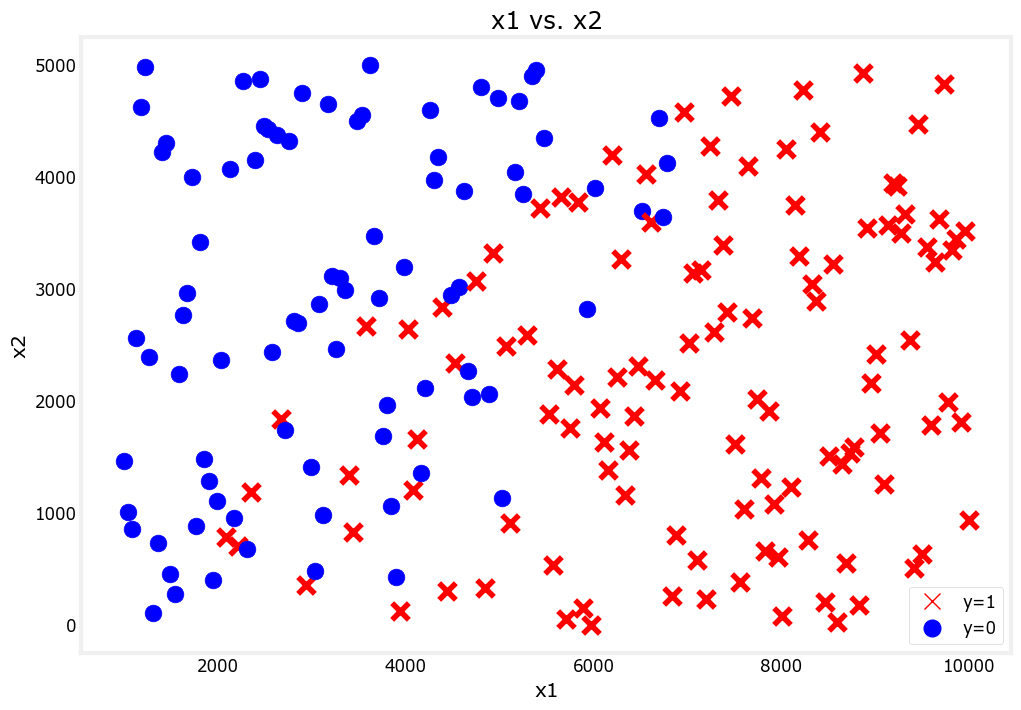

In [44]:
# Load data
data = np.loadtxt("./data/data_w3_ex2.csv", delimiter = ",")

# Split inputs, outputs into seperate arrays
x_bc = data[:,:-1]
y_bc = data[:,-1]

# Convert into 2D arrays 
y_bc = np.expand_dims(y_bc, axis = 1)

print(f"the shape of the inputs x is: {x_bc.shape}")
print(f"the shape of the targets y is: {y_bc.shape}")
utils.plot_bc_dataset(x=x_bc, y=y_bc, title="x1 vs. x2")

Note: Data consists of 200 data points, 2 input features and 1 classification (Binary). 

In [45]:
# Split the dataset
from sklearn.model_selection import train_test_split

# Get 60% of the dataset as the training set. Put the remaining 40% in temporary variables.
x_bc_train, x_, y_bc_train, y_ = train_test_split(x_bc, y_bc, test_size=0.40, random_state=1)

# Split the 40% subset above into two: one half for cross validation and the other for the test set
x_bc_cv, x_bc_test, y_bc_cv, y_bc_test = train_test_split(x_, y_, test_size=0.50, random_state=1)

# Delete temporary variables
del x_, y_

print(f"the shape of the training set (input) is: {x_bc_train.shape}")
print(f"the shape of the training set (target) is: {y_bc_train.shape}\n")
print(f"the shape of the cross validation set (input) is: {x_bc_cv.shape}")
print(f"the shape of the cross validation set (target) is: {y_bc_cv.shape}\n")
print(f"the shape of the test set (input) is: {x_bc_test.shape}")
print(f"the shape of the test set (target) is: {y_bc_test.shape}")

the shape of the training set (input) is: (120, 2)
the shape of the training set (target) is: (120, 1)

the shape of the cross validation set (input) is: (40, 2)
the shape of the cross validation set (target) is: (40, 1)

the shape of the test set (input) is: (40, 2)
the shape of the test set (target) is: (40, 1)


In [46]:
# Scale the features

# Initialize the class
scaler_linear = StandardScaler()

# Compute the mean and standard deviation of the training set then transform it
x_bc_train_scaled = scaler_linear.fit_transform(x_bc_train)
x_bc_cv_scaled = scaler_linear.transform(x_bc_cv)
x_bc_test_scaled = scaler_linear.transform(x_bc_test)

### Evaluating the error for classification models
In the regression models, we used MSE to measure the performance of the models. 
For classificatio models, we need to calculation the fraction of the model that has been misclassified. e.g. if the model made a wrong predictions on 2/5 samples, then the error will be 0,4. 

**The following code is just a general explanation**

In [50]:
# Sample model output
probabilities = np.array([0.2, 0.6, 0.7, 0.3, 0.8])

# Apply a threshold to the model output. If greater than 0.5, set to 1. Otherwise 0. 
predictions = np.where(probabilities >= 0.5, 1, 0)

# Ground truth labels 
ground_truth = np.array([1,1,1,1,1])

# Initialised counter for misclassified data
misclassified = 0

# Calculate number of predictions 
num_predictions = len(predictions)

# Loop over each prediction
for i in range(num_predictions):

    # Check if it matches the ground truth
    if predictions[i] != ground_truth[i]:

        # Update misclassification counter
        misclassified += 1

# Compute the fraction
fraction_error = misclassified / num_predictions 

print(f"Probabilities: {probabilities}")
print(f"predictions with threshold = 0.5: {predictions}")
print(f"targets: {ground_truth}")
print(f"fraction of misclassified data (for-loop): {fraction_error}")
print(f"fraction of misclassified data (with np.mean()): {np.mean(predictions != ground_truth)}")

Probabilities: [0.2 0.6 0.7 0.3 0.8]
predictions with threshold = 0.5: [0 1 1 0 1]
targets: [1 1 1 1 1]
fraction of misclassified data (for-loop): 0.4
fraction of misclassified data (with np.mean()): 0.4


### Build and train the model

In [75]:
# Initialise lists to store errors of each model
nn_train_error = []
nn_cv_error = []

# Build the models
models_bc = build_models()

# Loop over each model
for model in models_bc: 

    # Setup loss and optimizer
    model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
    )

    print(f"Training {model.name}...")

    # Train the model
    model.fit(
        x_bc_train_scaled, y_bc_train,
        epochs = 200,
        verbose = 0
    )
    
    print("Done!\n")
    
    # Set the threshold for classification
    threshold = 0.5

    # Record the fraction of misclassified examples for the training set
    yhat = model.predict(x_bc_train_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    train_error = np.mean(yhat != y_bc_train)
    nn_train_error.append(train_error)

    # Record the fraction of misclassified examples for the cross validation set
    yhat = model.predict(x_bc_cv_scaled)
    yhat = tf.math.sigmoid(yhat)
    yhat = np.where(yhat >= threshold, 1, 0)
    cv_error = np.mean(yhat != y_bc_cv)
    nn_cv_error.append(cv_error)

# Print the result
for model_num in range(len(nn_train_error)):
    print(
        f"Model {model_num+1}: Training Set Classification Error: {nn_train_error[model_num]:.5f}, " +
        f"CV Set Classification Error: {nn_cv_error[model_num]:.5f}"
        )

Training model_1...
Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Training model_2...
Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training model_3...
Done!

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Model 1: Training Set Classification Error: 0.03333, CV Set Classification Error: 0.15000
Model 2: Training Set Classification Error: 0.04167, CV Set Classification Error: 0.15000
Model 3: Training Set Classification Error: 0.06667, CV Set Classification Error: 0.15000


At last, we can compute the models generalisation error, knowing model 3 performed the best. Interesting observation: Since the model randomly picks data, different models may perform better or worse every time we run the code. Hence hard-coding that model 1 or model 2 or 3 is the best, is an error. 

In [76]:
# Select the model with the lowest error

# Convert lists into numpy arrays
np_nn_cv_error = np.array(nn_cv_error)
np_nn_train_error = np.array(nn_train_error)

print(np_nn_cv_error, np_nn_train_error)

# Find the minimum cv error
minimum_cv_error = np.min(np_nn_cv_error) #scalar
print(minimum_cv_error)

# If multiple indices, then list these indices into a second list such that we can find the minimum training set error
min_cv_indices = [i for i, v in enumerate(nn_cv_error) if v == minimum_cv_error]   # Sourced from https://stackoverflow.com/questions/15098642/getting-all-the-min-elements-and-its-indices-from-a-list
print(min_cv_indices)

# Find the subset of training errors that correspond to the minimum cv error
train_errors_consideration = np_nn_train_error[min_cv_indices]
print(train_errors_consideration)

# Find the minimum training error. 
minimum_train_error = np.min(train_errors_consideration)

# Find the model that is associated to the minimum training error of the subset of minimum cv errors. 
best_model = np.where(np_nn_train_error == minimum_train_error)[0][0] + 1

# Compute the test error
yhat = models_bc[model_num-1].predict(x_bc_test_scaled)
yhat = tf.math.sigmoid(yhat)
yhat = np.where(yhat >= threshold, 1, 0)
nn_test_error = np.mean(yhat != y_bc_test)

print(f"Selected Model: {best_model}")
print(f"Training Set Classification Error: {nn_train_error[best_model-1]:.4f}")
print(f"CV Set Classification Error: {nn_cv_error[best_model-1]:.4f}")
print(f"Test Set Classification Error: {nn_test_error:.4f}")

[0.15 0.15 0.15] [0.03 0.04 0.07]
0.15
[0, 1, 2]
[0.03 0.04 0.07]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Selected Model: 1
Training Set Classification Error: 0.0333
CV Set Classification Error: 0.1500
Test Set Classification Error: 0.1750
